In [26]:
import numpy as np
import pickle
from PIL import Image, ImageDraw
import matplotlib.pyplot  as plt
from matplotlib.pyplot import imshow
import cv2
import cv2
from simplelmdb import Simplelmdb
import lmdb
import numpy as np
import lmdb
import msgpack
import msgpack_numpy as m
m.patch()
import random
import shutil
import os
%matplotlib inline
from create_dataset import unnormalize

In [71]:
"""
Things to Plot:

Training Metrics:

batch loss vs error
metric accuracies (corresponding anchor points)
train loss vs val loss
train error vs val error
train metric accuracies vs test metric accurices
predicted displacement vs actual displacement
LEARNING_RATEA


** visualize gradients?
** visualize parameter space?

Dataset:
Anchor displacement distribution

Visualize

Frames with predicted displacements vs real displacements
Frames with predicted vs real anchors
Frames with predicted vs real splines

** last **
create videos of these frames



"""

'\nThings to Plot:\n\nTraining Metrics:\n\nbatch loss vs error\nmetric accuracies (corresponding anchor points)\ntrain loss vs val loss\ntrain error vs val error\ntrain metric accuracies vs test metric accurices\npredicted displacement vs actual displacement\nLEARNING_RATEA\n\n\n** visualize gradients?\n** visualize parameter space?\n\nDataset:\nAnchor displacement distribution\n\nVisualize\n\nFrames with predicted displacements vs real displacements\nFrames with predicted vs real anchors\nFrames with predicted vs real splines\n\n** last **\ncreate videos of these frames\n\n\n\n'

In [22]:
"""
Load Training Results
"""
history_dir = 'history/model_1/'

# load training history
training_history_file = history_dir + '/training_history.pkl'
with open(training_history_file) as f:
    training_history = pickle.load(f)
    
# load final predictions
predictions_file = history_dir + 'predictions.pkl'
with open(predictions_file) as f:
    predictions = pickle.load(f)
train_predictions = predictions['train']  
test_predictions = predictions['test']  



In [ ]:
"""    
Load Ground Truths    
"""
dataset_dir = 'data/datasets/single_lane_front'
train_dir = dataset_dir + '/train.lmdb'
test_dir = dataset_dir + '/test.lmdb'
train_db = Simplelmdb(train_dir)
test_db = Simplelmdb(test_dir)

In [79]:
def plot_gt_vs_pred(db, pred, target_index, normalized=False):
    """
    histories - dictionary of history arrays
    """
    n = db.get('num_records')    
    
    x = []
    y = []
    for i in range(n):
        sample = db.get(str(i))
        low = db.get('low')
        high = db.get('high')
        data_min = db.get('data_min')
        data_max = db.get('data_max')
        gt_displacements = sample['image_targets']
        pred_displacements = pred[i]
        
        if not normalized:
            gt_displacements = unnormalize(gt_displacements,low, high, data_min, data_max)
            pred_displacements = unnormalize(pred_displacements,low, high, data_min, data_max)
        x.append(gt_displacements[target_index])
        y.append(pred_displacements[target_index])
    plt.scatter(x, y)
    plt.title('gt vs pred for displacement ' + str(target_index))
    plt.xlabel('pred')
    plt.ylabel('gt')
    plt.show()
    

In [5]:
"""
Loss
"""
"""
mean_absolute_error
"""

'\nmean_absolute_error\n'

In [6]:
def plot_history(batches, histories):
    """
    histories - dictionary of history arrays
    """
    colors = ["#023fa5", "#d6bcc0", "#bb7784", "#8e063b", "#4a6fe3", "#8595e1", "#b5bbe3", "#e6afb9", "#e07b91", "#d33f6a", "#11c638", "#8dd593", "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0", "#9cded6", "#d5eae7", "#f3e1eb", "#f6c4e1", "#f79cd4"]
    batches_per_epoch = len(batches)
    for (batch, epoch) in batches:
        if epoch == 1:
            batches_per_epoch = batch
            break
    num_batches = len(batches)
    print batches_per_epoch
    plt.figure()
    handles = []
    
    max_len = 0
    color_index = 0
    for history, values in histories.iteritems():
        color = colors[color_index]
        color_index+=1
        batches = range(len(values))
        max_len = max(max_len, len(values))
        line = plt.scatter(batches, values, label=history, color= color)
        handles.append(line)

    plt.legend(handles=handles)
    
    epoch_ticks = np.arange(0, num_batches, batches_per_epoch)
    tick_labels = [str(i/batches_per_epoch) for i in epoch_ticks]
    plt.xticks(epoch_ticks, tick_labels)
    
    plt.xlabel('epoch')
    plt.show()
    

In [70]:
from scipy import interpolate

def visualize_lanes(db, predictions, index, viz_gt=False, viz_pred=False, viz_splines=False, viz_anchors=True, viz_displacements=False):
    sample = db.get(str(index))
    low = db.get('low')
    high = db.get('high')
    data_min = db.get('data_min')
    data_max = db.get('data_max')
    image = sample['image_data'].astype('uint8')
    center_x = image.shape[1]/2
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image) 
    anchor_points = sample['anchor_points']
    
    gt_displacements = sample['image_targets']
    gt_displacements = unnormalize(gt_displacements,low, high, data_min, data_max)
    
    pred_displacements = predictions[index]
    pred_displacements = unnormalize(pred_displacements,low, high, data_min, data_max)
    
    gt_colors = [(255,0,0),(0,0,255)]
    pred_colors = [(200,0,0),(0,0,200)]
    
    to_viz = []
    
    if viz_gt:
        to_viz.append((gt_displacements, gt_colors))
    
    if viz_pred:
        to_viz.append((pred_displacements, pred_colors))

    for (displacements, colors) in to_viz:
        if viz_anchors:
            draw_anchors(draw, center_x, anchor_points, displacements, colors)
        if viz_splines:
            draw_splines(draw, center_x, anchor_points, displacements, colors)
        if viz_displacements:
            draw_displacements(draw, center_x, anchor_points, displacements, colors)            

    plt.figure()
    plt.imshow(image)

def draw_anchors(draw, center_x, anchor_points, displacements, colors, dx=2, dy=2):
    for i in range(anchor_points.shape[0]):
        color = colors[0] if i <3 else colors[1]
        anchor_point = anchor_points[i].astype(int)
        x = center_x + displacements[i]
        y = anchor_point[1]
        rect = [x-dx, y-dy,x+dx, y+dy]
        draw.rectangle(rect, fill=color)  


def draw_splines(draw, center_x, anchor_points, displacements, colors, width=1):
    for i in range(anchor_points.shape[0]/3):
        color = colors[i]
        # spline i
        # get 3 anchor points, draw
        i1 = i*3
        i2 = i*3 + 1
        i3 = i*3 + 2
        a1 = anchor_points[i1]
        a2 = anchor_points[i2]
        a3 = anchor_points[i3]
        x1 = center_x + displacements[i1] 
        x2 = center_x + displacements[i2] 
        x3 = center_x + displacements[i3] 
        y1 = a1[1]
        y2 = a2[1]
        y3 = a3[1]

        spline_anchor_points = [ (x1, y1), (x2, y2), (x3,y3)]
        spline_points = compute_bezier_points(spline_anchor_points, 10)
        draw.line(spline_points, fill=color, width=width)

def draw_displacements(draw, center_x, anchor_points, displacements, colors, width=1):
    for i in range(anchor_points.shape[0]):
        color = colors[0] if i <3 else colors[1]
        anchor_point = anchor_points[i].astype(int)
        x1 = center_x
        x2 = x1 + displacements[i]
        y = anchor_point[1]
        line = [ x1, y, x2, y]
        draw.line(line, fill=color, width=width)

def compute_bezier_points(anchor_points, n):
    """
    returns n bezier points that fir a curve from the anchor points.
    These points can be used to draw a line
    """
    x = [p[0] for p in anchor_points]
    y = [p[1] for p in anchor_points]
    tck,u = interpolate.splprep( [x,y], k = 2)
    xnew,ynew = interpolate.splev( np.linspace( 0, 1, n ), tck,der = 0)
    return [c for p in zip(xnew, ynew) for c in p]


469


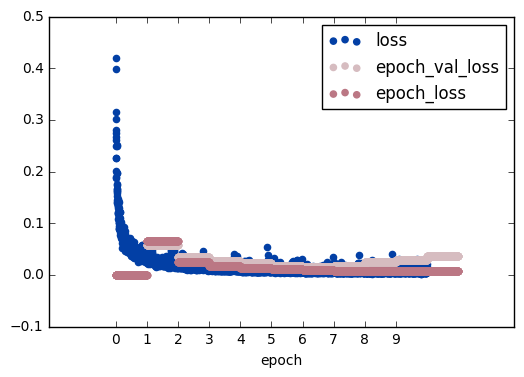

In [7]:
histories = dict((k, training_history['history'][k]) for k in ['loss'])
epoch_histories = dict(('epoch_'+k, training_history['epoch_history'][k]) for k in ['loss', 'val_loss'])
histories.update(epoch_histories)
batch = training_history['batch']
plot_history(batch, histories)

469


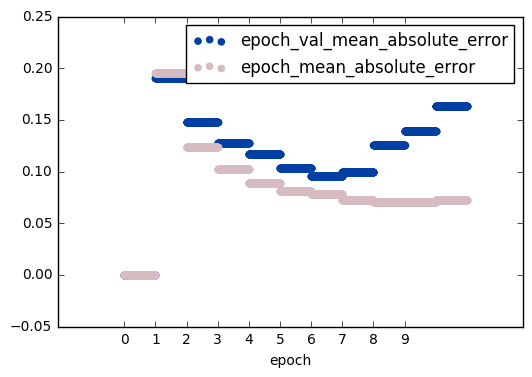

In [8]:
histories = {}#dict((k, data['history'][k]) for k in ['mean_absolute_error'])
epoch_histories = dict(('epoch_'+k, training_history['epoch_history'][k]) for k in ['mean_absolute_error', 'val_mean_absolute_error'])
histories.update(epoch_histories)
batch = training_history['batch']
plot_history(batch, histories)

469


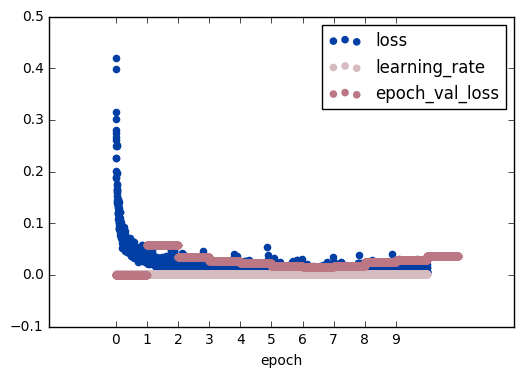

In [9]:
histories = dict((k, training_history['history'][k]) for k in ['learning_rate', 'loss'])
epoch_histories = dict(('epoch_'+k, training_history['epoch_history'][k]) for k in ['val_loss'])
histories.update(epoch_histories)
batch = training_history['batch']
plot_history(batch, histories)

469


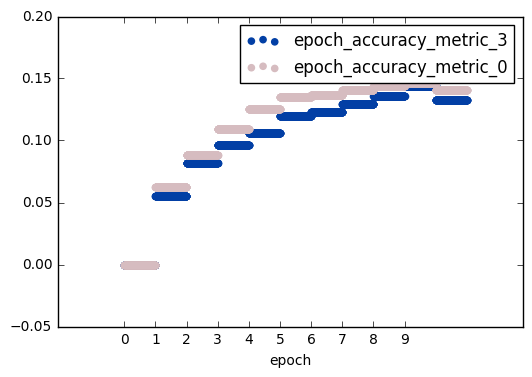

469


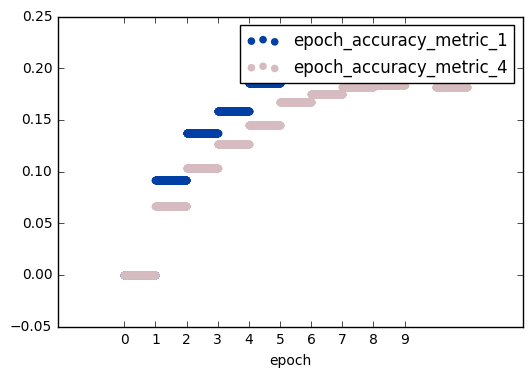

469


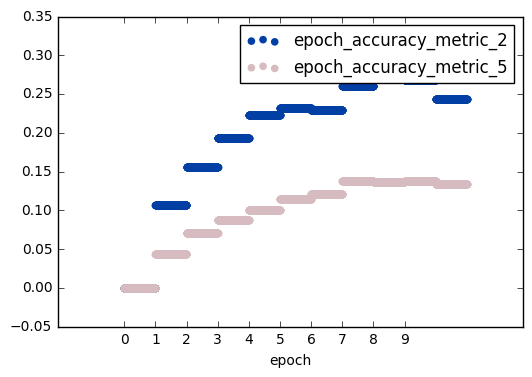

In [10]:
for (a1, a2) in [('accuracy_metric_0', 'accuracy_metric_3'), ('accuracy_metric_1', 'accuracy_metric_4'),('accuracy_metric_2', 'accuracy_metric_5')]:
    histories = {}# dict((k, training_history['history'][k]) for k in  [a1, a2])
    epoch_histories = dict(('epoch_'+k, training_history['epoch_history'][k]) for k in [a1, a2])
    histories.update(epoch_histories)
    batch = training_history['batch']
    plot_history(batch, histories)

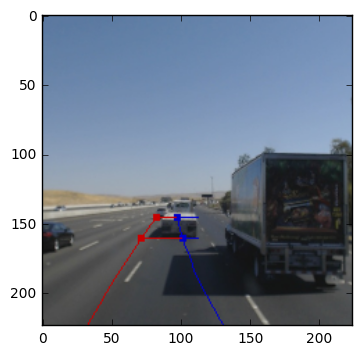

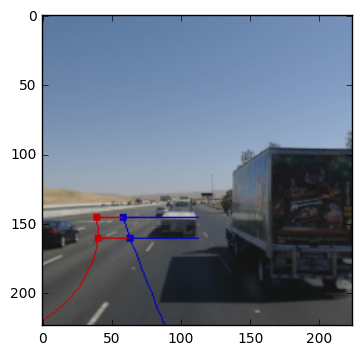

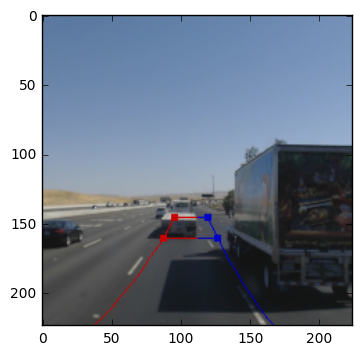

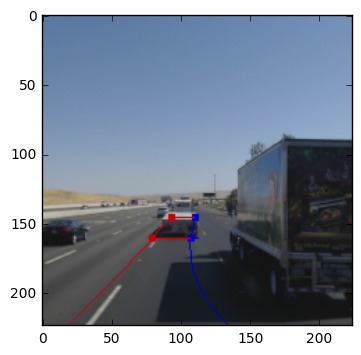

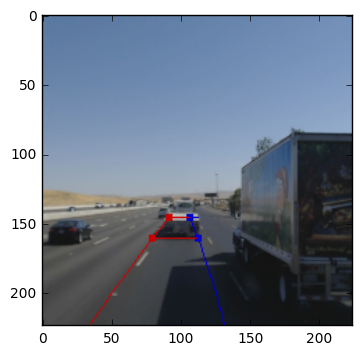

In [82]:
# Train Prediction Visualization
for i in range(0,100,20):
    visualize_lanes(train_db, train_predictions, i, viz_pred=True, viz_anchors=True, viz_displacements=True, viz_splines=True)

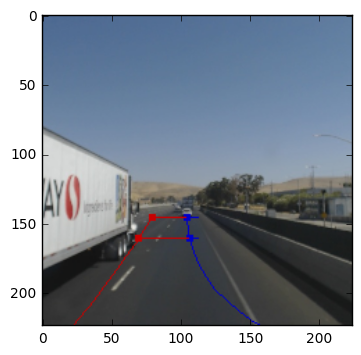

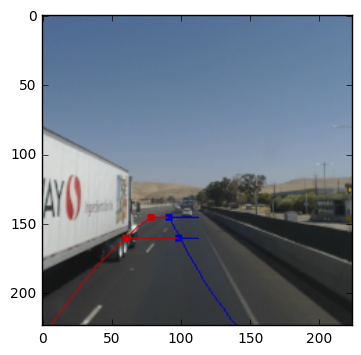

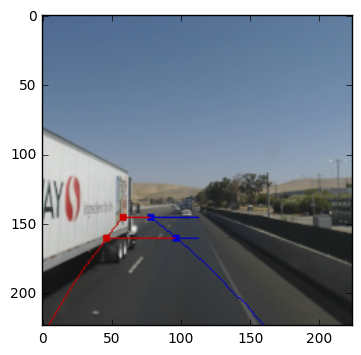

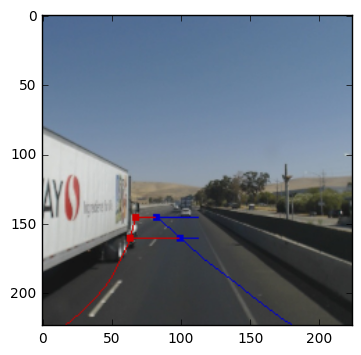

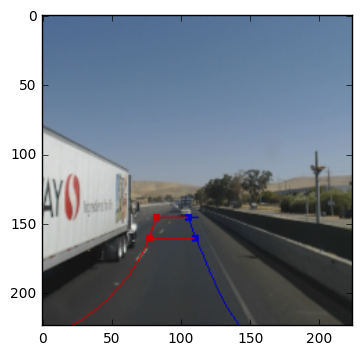

In [83]:
# Test Prediction Visualization
for i in range(0,100,20):
    visualize_lanes(test_db, test_predictions, i, viz_pred=True, viz_anchors=True, viz_displacements=True, viz_splines=True)

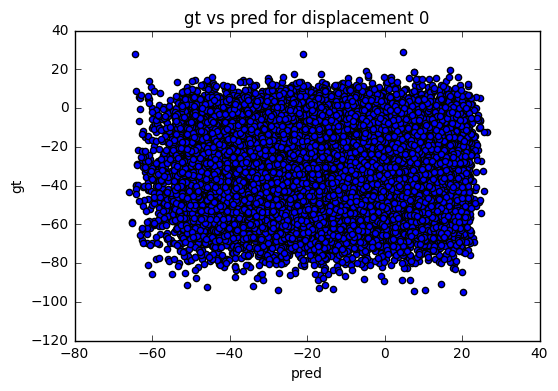

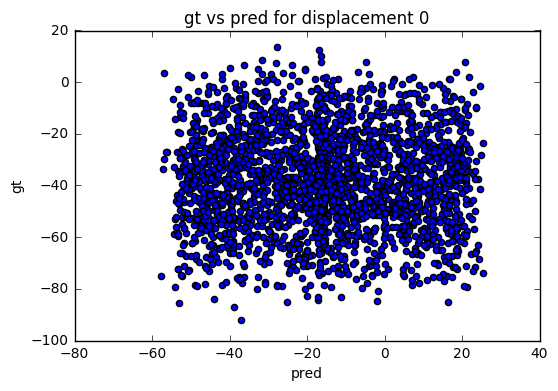

In [81]:
plot_gt_vs_pred(train_db, train_predictions, 0)
plot_gt_vs_pred(test_db, test_predictions, 0)